# Network analysis for differentially spliced genes


In [1]:
from datetime import datetime; print("START:", datetime.now())
import socket; print("Simons Foundation, Rusty HPC,", socket.gethostname())

START: 2021-08-02 23:54:24.857934
Simons Foundation, Rusty HPC, worker3129


In [2]:
%cd /mnt/home/zzhang/ceph/CHARM-AlternativeSplicing
%load_ext rpy2.ipython

/mnt/ceph/users/zzhang/jemm


## 1. Network parsing

In [3]:
import pandas as pd
from io import StringIO
import networkx
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
plt.style.use(['science', 'no-latex', 'ieee'])

DATA_VER = 'data-V7'

%run ./notebook/navy_utils.py $DATA_VER

navy_utils.py data-V7 [] False


In [4]:
def find_module_genes(f):
    module_genes = {}
    while 1:
        line = f.readline().strip()
        if len(line) == 0:
            print('finish module genes')
            return module_genes
        ele = line.split()
        module_genes[ele[0]] = ele[1].split(',')

def find_module_gos(f):
    s = ""
    while 1:
        line = f.readline()
        if len(line.strip()) == 0:
            print('finish module gos')
            break
        else:
            s += line
    mock_file = StringIO(s)
    return pd.read_csv(mock_file, header=None,
                       names=['CLUSTER_NAME', 'TERM_NAME', 'GO_ID', 'TERM_Q_VALUE', 'GENE_COUNT', 'TERM_GENES'], sep="\t")

def find_edges(f):
    s = ''
    for line in f:
        s += line.strip() + '\n'
    print('finish edges')
    edges = pd.read_csv(StringIO(s), header=None, sep="\t",
                        names=['SOURCE', 'TARGET', 'WEIGHT'])
    return edges

In [5]:
def parse_humanbase_tsv(fp):
    info_headers = ['GO_VERSION', 'NETWORK_NAME', 'NETWORK_VERSION', 'DATE_CREATED']
    cluster_headers = ['CLUSTER_NAME']
    edge_headers = ['SOURCE']

    lines = 0
    with open(fp, 'r') as f:
        seen_cluster_header = 0
        eof = False
        for line in f:
            lines += 1
            ele = line.strip().split()
            if len(ele) == 0:
                continue
            if ele[0] in cluster_headers:
                # first occurrence is module memebers
                if seen_cluster_header == 0:
                    module_genes = find_module_genes(f)
                    seen_cluster_header += 1
                    continue
                elif seen_cluster_header == 1:
                    module_gos = find_module_gos(f)
                    continue
            if ele[0] in edge_headers:
                edges = find_edges(f)
    return module_genes, module_gos, edges

In [6]:
m_gen, m_go, m_es = parse_humanbase_tsv('./%s/all_genes_splicing.gender/HumanBase/blood_male_hb.tsv' % DATA_VER)
f_gen, f_go, f_es = parse_humanbase_tsv('./%s/all_genes_splicing.gender/HumanBase/blood_female_hb.tsv' % DATA_VER)

finish module genes
finish module gos
finish edges
finish module genes
finish module gos
finish edges


In [7]:
def get_representative_go(go_df, top_k=3):
    seen_genes = set([])
    df = go_df.sort_values('TERM_Q_VALUE', ascending=True)
    reps = []
    gos = []
    for i in range(df.shape[0]):
        this_genes = set(df.iloc[i]['TERM_GENES'].split(','))
        if len(this_genes.intersection(seen_genes)) >= len(this_genes) * 0.75:
            for g in this_genes: seen_genes.add(g)
            continue
        else:
            for g in this_genes: seen_genes.add(g)
        reps.append(df.iloc[i]['TERM_NAME'])
        gos.append(df.iloc[i]['GO_ID'])
        if len(reps) >= top_k:
            break
    return reps, gos

In [8]:
# module match between male and female

overlap_threshold = 0.5

shared_module_df = pd.DataFrame(columns=['shared', 'representative_go', 
                                         'male', 'female', 'n_male', 'n_female', 
                                         'overlapped',
                                         'male_genesize',
                                         'female_genesize',
                                        ])
shared = 1
for m_mod in m_go['CLUSTER_NAME'].unique():
    m_mod_go = set(m_go.loc[m_go['CLUSTER_NAME']==m_mod, 'GO_ID'].to_list())
    m_mod_len = len(m_mod_go)
    m_geneset = set([g for x in m_go.loc[m_go['CLUSTER_NAME']==m_mod, 'TERM_GENES'].to_list() for g in x.split(',')])
    m_reps, _ = get_representative_go(m_go.loc[m_go['CLUSTER_NAME']==m_mod], top_k=2)
    for f_mod in f_go['CLUSTER_NAME'].unique():
        f_mod_go = set(f_go.loc[f_go['CLUSTER_NAME']==f_mod, 'GO_ID'].to_list())
        f_mod_len = len(f_mod_go)
        f_geneset = set([g for x in f_go.loc[f_go['CLUSTER_NAME']==f_mod, 'TERM_GENES'].to_list() for g in x.split(',')])
        overlapped = m_mod_go.intersection(f_mod_go)
        if len(overlapped) > overlap_threshold * m_mod_len or len(overlapped) > overlap_threshold * f_mod_len:
            f_reps, _ = get_representative_go(f_go.loc[f_go['CLUSTER_NAME']==f_mod], top_k=2)
            #print(', '.join(list(set(m_reps + f_reps))))
            shared_module_df = shared_module_df.append({
                'shared': 'S%i'%shared,
                'representative_go': ', '.join(list(set(m_reps + f_reps))),
                'male': m_mod,
                'female': f_mod,
                'n_male': m_mod_len,
                'n_female': f_mod_len,
                'overlapped': len(overlapped),
                'male_genesize': len(m_geneset),
                'female_genesize': len(f_geneset)
            }, ignore_index=True)
            shared += 1

for m_mod in m_go['CLUSTER_NAME'].unique():
    if m_mod not in shared_module_df['male'].values:
        shared_module_df = shared_module_df.append({
            'shared': 'S%i'%shared,
            'male': m_mod,
            'representative_go': ', '.join(get_representative_go(m_go.loc[m_go['CLUSTER_NAME']==m_mod], top_k=2)[0]),
            'n_male': len(m_go.loc[m_go['CLUSTER_NAME']==m_mod, 'GO_ID'].to_list())
        }, ignore_index=True)
        shared += 1
        
for f_mod in f_go['CLUSTER_NAME'].unique():
    if f_mod not in shared_module_df['female'].values:
        shared_module_df = shared_module_df.append({
            'shared': 'S%i'%shared,
            'female': f_mod,
            'representative_go': ', '.join(get_representative_go(f_go.loc[f_go['CLUSTER_NAME']==f_mod], top_k=2)[0]),
            'n_female': len(f_go.loc[f_go['CLUSTER_NAME']==f_mod, 'GO_ID'].to_list())
        }, ignore_index=True)
        shared += 1
            
shared_module_df

,shared,representative_go,male,female,n_male,n_female,overlapped,male_genesize,female_genesize
0,S1,"DNA conformation change, mitotic nuclear divis...",M1,M1,322,314,235,129,144
1,S2,"leukocyte activation, immune effector process",M2,M2,363,335,256,105,120
2,S3,"bone cell development, vesicle organization, h...",M3,M4,178,182,110,102,125
3,S4,"positive regulation of sodium ion transport, c...",M5,M6,27,9,5,21,9
4,S5,"positive regulation of histone deacetylation, ...",M4,NaN,113,NaN,NaN,NaN,NaN
5,S6,"peptide metabolic process, rRNA processing",NaN,M3,NaN,42,NaN,NaN,NaN
6,S7,negative regulation of intracellular signal tr...,NaN,M5,NaN,222,NaN,NaN,NaN


In [9]:
# for exon splicing, we will need the original gene-exon separation
# because in one gene could have shared exon and specific exon at the same time
# we will prioritize the specific exon to a gene if possible
with open('%s/all_genes_splicing.gender/human_readable/male_specific_genes.2.txt'% DATA_VER, 'r') as f:
    m_uniq_genes = [x.strip() for x in f.readlines()]

with open('%s/all_genes_splicing.gender/human_readable/female_specific_genes.2.txt'% DATA_VER, 'r') as f:
    f_uniq_genes = [x.strip() for x in f.readlines()]

m_uniq_genes_ = [g for g in m_uniq_genes if g not in f_uniq_genes]
f_uniq_genes_ = [g for g in f_uniq_genes if g not in m_uniq_genes]

m_uniq_genes, f_uniq_genes = m_uniq_genes_, f_uniq_genes_
print(len(m_uniq_genes))
print(len(f_uniq_genes))

265
361


In [10]:
with open('%s/all_genes_splicing.gender/human_readable/male_stronger_genes.2.txt'% DATA_VER, 'r') as f:
    m_st_genes = [x.strip() for x in f.readlines()]
    m_st_genes = [g for g in m_st_genes if g not in m_uniq_genes and g not in f_uniq_genes]
    
with open('%s/all_genes_splicing.gender/human_readable/female_stronger_genes.2.txt'% DATA_VER, 'r') as f:
    f_st_genes = [x.strip() for x in f.readlines()]
    f_st_genes = [g for g in f_st_genes if g not in m_uniq_genes and g not in f_uniq_genes]

m_st_genes_ = [g for g in m_st_genes if g not in f_st_genes]
f_st_genes_ = [g for g in f_st_genes if g not in m_st_genes]

m_st_genes, f_st_genes = m_st_genes_, f_st_genes_
print(len(m_st_genes))
print(len(f_st_genes))

7
165


In [11]:
def get_module_coverage(genes, module_genes, return_num=True):
    mod_overlap = {}
    for mod in module_genes:
        mod_len = len(module_genes[mod])
        overlap = [g for g in module_genes[mod] if g in genes]
        if return_num is True:
            mod_overlap[mod] = len(overlap)
        else:
            mod_overlap[mod] = len(overlap) / mod_len
        
    return mod_overlap


In [12]:
# merge modules
s_mods = {}
for i in range(shared_module_df.shape[0]):
    s = shared_module_df.iloc[i]['shared']
    m = shared_module_df.iloc[i]['male']
    f = shared_module_df.iloc[i]['female']
    m = m_gen[m] if pd.notna(m) else []
    f = f_gen[f] if pd.notna(f) else []
    s_mods[s] = list(set(m + f))

In [13]:
m_cov = get_module_coverage(m_st_genes, s_mods)
for i in range(shared_module_df.shape[0]):
    if pd.isna(shared_module_df.iloc[i]['male']):
        shared_module_df.at[i, 'Male stronger'] = 0
    else:
        shared_module_df.at[i, 'Male stronger'] = m_cov[shared_module_df.iloc[i]['shared']]

In [14]:
m_cov = get_module_coverage(m_uniq_genes, s_mods)
for i in range(shared_module_df.shape[0]):
    if pd.isna(shared_module_df.iloc[i]['male']):
        shared_module_df.at[i, 'Male specific'] = 0
    else:
        shared_module_df.at[i, 'Male specific'] = m_cov[shared_module_df.iloc[i]['shared']]

In [15]:
f_cov = get_module_coverage(f_st_genes, s_mods)
for i in range(shared_module_df.shape[0]):
    if pd.isna(shared_module_df.iloc[i]['female']):
        shared_module_df.at[i, 'Female stronger'] = 0
    else:
        shared_module_df.at[i, 'Female stronger'] = f_cov[shared_module_df.iloc[i]['shared']]

In [16]:
f_cov = get_module_coverage(f_uniq_genes, s_mods)
for i in range(shared_module_df.shape[0]):
    if pd.isna(shared_module_df.iloc[i]['female']):
        shared_module_df.at[i, 'Female specific'] = 0
    else:
        shared_module_df.at[i, 'Female specific'] = f_cov[shared_module_df.iloc[i]['shared']]

In [17]:
shared_module_df['Total Genes'] = [len(s_mods[x]) for x in shared_module_df['shared']]
shared_module_df['Shared DAS genes'] = shared_module_df['Total Genes'] - shared_module_df['Male specific'] - shared_module_df['Female specific'] - \
    shared_module_df['Male stronger'] - shared_module_df['Female stronger']
shared_module_df

,shared,representative_go,male,female,n_male,n_female,overlapped,male_genesize,female_genesize,Male stronger,Male specific,Female stronger,Female specific,Total Genes,Shared DAS genes
0,S1,"DNA conformation change, mitotic nuclear divis...",M1,M1,322,314,235,129,144,0.0,41.0,14.0,52.0,288,181.0
1,S2,"leukocyte activation, immune effector process",M2,M2,363,335,256,105,120,3.0,53.0,35.0,66.0,312,155.0
2,S3,"bone cell development, vesicle organization, h...",M3,M4,178,182,110,102,125,2.0,35.0,21.0,65.0,354,231.0
3,S4,"positive regulation of sodium ion transport, c...",M5,M6,27,9,5,21,9,1.0,37.0,15.0,21.0,208,134.0
4,S5,"positive regulation of histone deacetylation, ...",M4,NaN,113,NaN,NaN,NaN,NaN,1.0,67.0,0.0,0.0,294,226.0
5,S6,"peptide metabolic process, rRNA processing",NaN,M3,NaN,42,NaN,NaN,NaN,0.0,0.0,12.0,12.0,52,28.0
6,S7,negative regulation of intracellular signal tr...,NaN,M5,NaN,222,NaN,NaN,NaN,0.0,0.0,42.0,77.0,308,189.0


In [18]:
plot_df = shared_module_df.copy()
plot_df.index = plot_df['shared']

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        lab = '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
        if pct == 0:
            lab = ''
        return lab
    return my_autopct
    
fig, axs = plt.subplots(4, 3, figsize=(25, 25))
rcnt = 0
ccnt = 0
for i, smod in enumerate(plot_df.index):
    #print(rcnt, ccnt)
    ax = axs[rcnt, ccnt]
    ccnt += 1
    if i>= (1+rcnt)*3-1:
        rcnt += 1
        ccnt = 0
    to_plot = ['Male specific', 'Male stronger', 
               'Female specific', 'Female stronger',
               'Shared DAS genes']
    plot_df.loc[smod, to_plot].plot.pie(
        #autopct="%.1f%%",
        autopct=make_autopct(plot_df.loc[smod, to_plot]),
        colors=[
            '#3393ff', # blue
            '#b7d8fe', # light blue
            '#FFA500', # orange
            '#F9E9CA', # light orange
            '#87b57d', # green
        ],
        labels=None,
        fontsize=20,
        ax=ax)
    ax.set_title(plot_df.loc[smod, 'representative_go'].replace(',', '\n'), horizontalalignment='center', 
                 fontsize=18)
    ax.set_ylabel('')
fig.tight_layout()
fig.savefig('%s/all_genes_splicing.gender/figs/02-network_module_pies.pdf' % DATA_VER)

## 2. Network reconstruction

In [19]:
def add_nodes(G, net_genes, uniq_genes, sex):
    """
    net_genes : dict, module -> genes
    uniq_genes : list
    """
    for mod in net_genes:
        for g in net_genes[mod]:
            if g in uniq_genes:
                sex_dependence = sex
            else:
                sex_dependence = 'shared'
            module = shared_module_df.loc[shared_module_df[sex].values==mod, 'shared'].values[0]
            if G.has_node(g):
                n = G.nodes[g]
                if n['sex_dependence'] == 'shared':
                    n['sex_dependence'] = sex_dependence
                elif n['sex_dependence'] == sex_dependence:
                    pass
                else:
                    n['sex_dependence'] += ','+sex_dependence
            else:
                G.add_node(g, module=module, sex_dependence=sex_dependence)
    return G

def add_edges(G, edges):
    for i in range(edges.shape[0]):
        s, t, w = edges.iloc[i][['SOURCE', 'TARGET', 'WEIGHT']]
        G.add_edge(s, t, weight=w)
    return G

In [20]:
G = networkx.Graph()

add_nodes(G, m_gen, m_uniq_genes+m_st_genes, 'male')
add_nodes(G, f_gen, f_uniq_genes+f_st_genes, 'female')

In [21]:
add_edges(G, m_es)
add_edges(G, f_es)

## 3. Hubiness analysis

In [22]:
hubiness = {}
for node in G.nodes(data=True):
    if len(node[1]) == 0:
        continue
    edges = [e for e in G.edges(node[0], data=True)]
    hubiness[node[0]] = {
        'Node_type': node[1]['sex_dependence'],
        'connectivity': sum([e[2]['weight'] for e in edges]),
        'module': node[1]['module']
    }

In [23]:
hub_df = pd.DataFrame.from_dict(hubiness, orient='index').sort_values('connectivity', ascending=False)
hub_df['log10(connectivity)'] = np.log10(hub_df['connectivity'])

In [24]:
ks_m=scipy.stats.ks_2samp(hub_df.query('Node_type=="shared"')['log10(connectivity)'], hub_df.query('Node_type=="male"')['log10(connectivity)'])
ks_f=scipy.stats.ks_2samp(hub_df.query('Node_type=="shared"')['log10(connectivity)'], hub_df.query('Node_type=="female"')['log10(connectivity)'])
ks_fm = scipy.stats.ks_2samp(hub_df.query('Node_type=="male"')['log10(connectivity)'], hub_df.query('Node_type=="female"')['log10(connectivity)'])
ks_fm

KstestResult(statistic=0.15097912202899996, pvalue=0.013960640311697525)

In [25]:
print('shared mean con = %f' % hub_df.query('Node_type=="shared"')['log10(connectivity)'].mean())
print('male mean con = %f' % hub_df.query('Node_type=="male"')['log10(connectivity)'].mean())
print('female mean con = %f' % hub_df.query('Node_type=="female"')['log10(connectivity)'].mean())

shared mean con = -0.059262
male mean con = -0.224864
female mean con = -0.062002


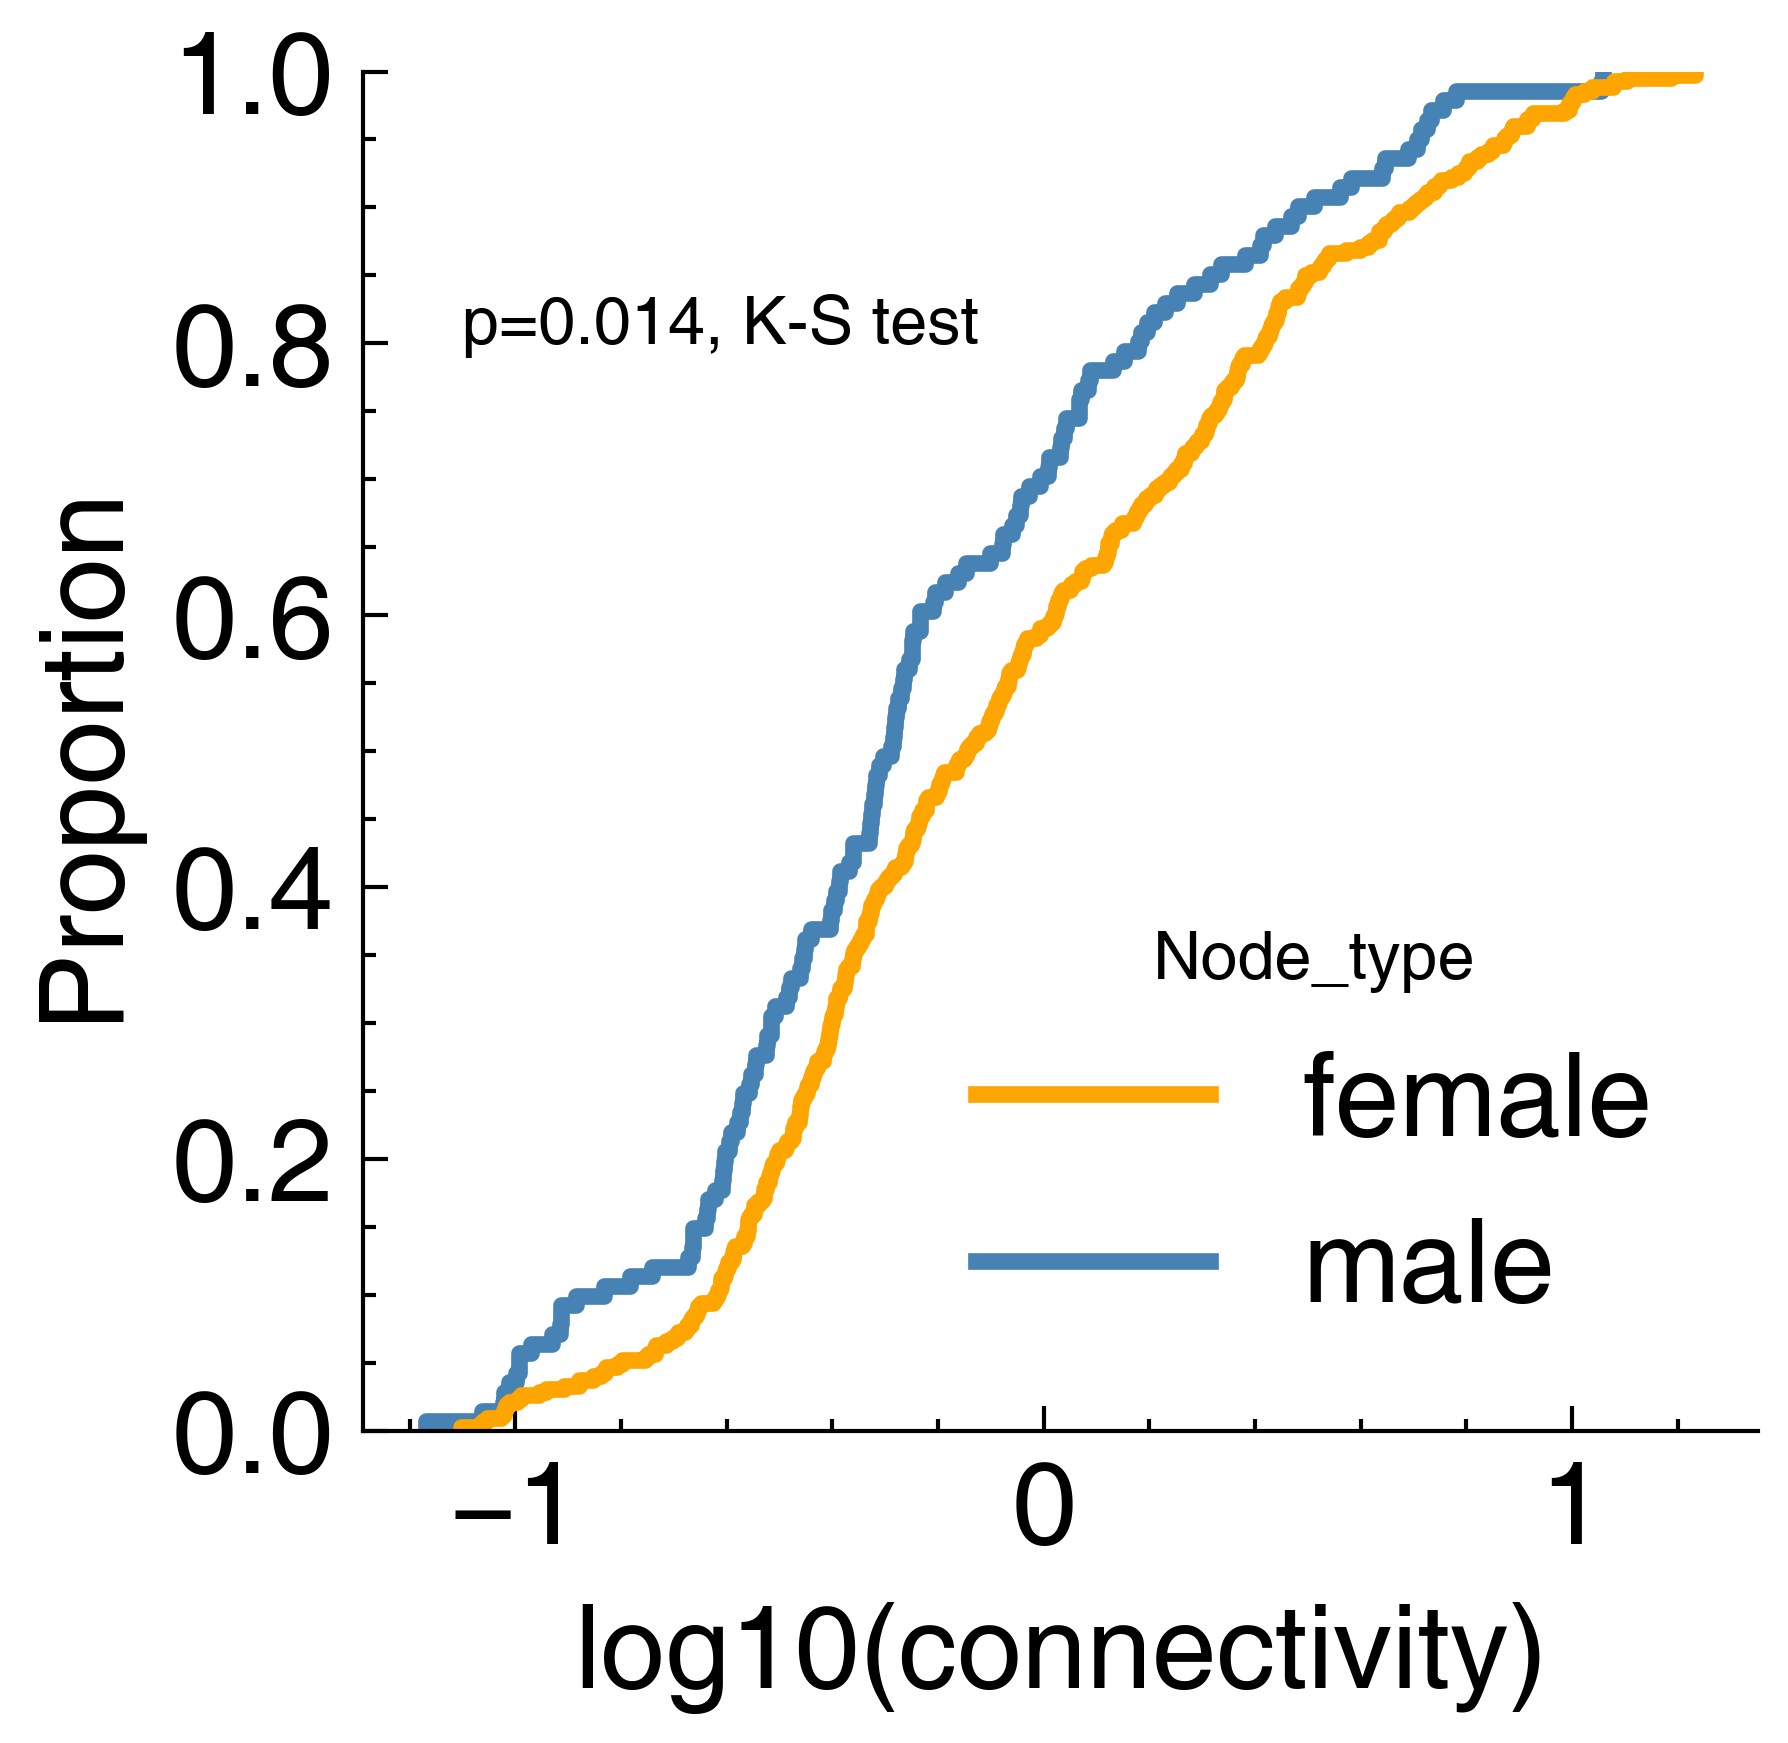

In [26]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
sns.ecdfplot(x='log10(connectivity)', hue='Node_type',
             hue_order=['female', 'male'],
             data=hub_df[hub_df['Node_type'].isin(('female', 'male'))], 
             palette=[
            'orange',
            'steelblue'
            ],
             linewidth=2,
             ls='-',
             ax=ax)
#ax.legend(
#    labels=[
#    'Shared, n=%i' % (hub_df['Node_type']=="shared").sum(),
#    'Male-specific, n=%i\np=%.1e' % ((hub_df['Node_type']=="male").sum(), ks_m.pvalue),
#    'Female-specific, n=%i\np=%.1e' % ((hub_df['Node_type']=="female").sum(), ks_f.pvalue),
#    ],    
#    bbox_to_anchor=(1, 1.05), 
#    loc='upper left')
ax.text(s='p=%.3f, K-S test'%ks_fm.pvalue, x=-1.1, y=0.8)
fig.savefig('%s/all_genes_splicing.gender/figs/03-network_connectivity.pdf' % DATA_VER)

In [27]:
hub_df.loc['CASP8']

Node_type                female
connectivity            2.61074
module                       S2
log10(connectivity)    0.416763
Name: CASP8, dtype: object

In [28]:
# these will be good candidates to analyze; need to go back to notebook 11 for sex-dependent events analysis
hub_df.query('Node_type!="shared" and module=="S2"').to_csv('%s/all_genes_splicing.gender/figs/04-immune_module_genes.tsv' % DATA_VER, index=True, sep="\t")
hub_df.query('Node_type!="shared" and module=="S2"')

,Node_type,connectivity,module,log10(connectivity)
CASP1,"male,shared",26.511815,S2,1.423439
PSME2,female,15.381983,S2,1.187012
OAS2,female,11.954827,S2,1.077543
SOD2,male,11.470469,S2,1.059581
CORO1A,female,10.016212,S2,1.000704
...,...,...,...,...
MME,female,0.242188,S2,-0.615847
MLKL,"male,shared",0.220415,S2,-0.656759
SPATS2L,female,0.209947,S2,-0.677890
GLT1D1,female,0.203307,S2,-0.691848


In [29]:
print("FINISH:", datetime.now())

FINISH: 2021-08-02 23:55:01.128926
